# Analizador de sentimientos para comentarios de películas utilizando Redes Neuronales y Word Embeddings

## Paso 1 - Lectura del conjunto de información

In [12]:
# Importar todas las librerías que se utilizarán
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
# Importar todas las librerías que se utilizarán
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt


In [13]:
# Leemos el archivo y mostramos los primeros elementos para verificar
# que sean los correctos
movie_reviews = pd.read_csv("Reseñas de películas.csv")
# Verificar que no existan valore nulos
print("Existen valores nulos:")
print(movie_reviews.isnull().values.any())
movie_reviews.head(10)

Existen valores nulos:
False


,original,sentimiento,reseña
0,One of the other reviewers has mentioned that ...,positive,Uno de los otros críticos han mencionado que d...
1,A wonderful little production. <br /><br />The...,positive,Una producción pequeña y maravillosa. <br /> <...
2,I thought this was a wonderful way to spend ti...,positive,Pensé que esto era una maravillosa manera de p...
3,Basically there's a family where a little boy ...,negative,Básicamente hay una familia en la que un niño ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei de ""amor en los tiempos del dine..."
5,"Probably my all-time favorite movie, a story o...",positive,Probablemente mi película favorita de todos lo...
6,I sure would like to see a resurrection of a u...,positive,Estoy seguro que le gustaría ver una resurrecc...
7,"This show was an amazing, fresh & innovative i...",negative,"Este espectáculo fue una increíble, fresca y i..."
8,Encouraged by the positive comments about this...,negative,Alentados por los comentarios positivos sobre ...
9,If you like original gut wrenching laughter yo...,positive,Si te gusta la risa desgarradora original que ...


In [14]:
# Imprimimos uno de los ejemplos para revisar su escritura
movie_reviews["reseña"][1] # Algún número de ejemplo

'Una producción pequeña y maravillosa. <br /> <br /> La técnica de filmación es muy unassuming- muy de moda en tiempo pasado de la BBC y da una reconfortante, ya veces discomforting, sensación de realismo a toda la pieza. <br /> <br /> Los actores están muy bien elegido-Michael Sheen no sólo "tiene todas las polari", pero tiene todas las voces al dedillo también! Se puede ver realmente el transparente la edición guiada por las referencias a las entradas del diario de Williams, no sólo es bien digno de la observación, sino que es una pieza terrificly escrita e interpretada. Una producción magistral sobre uno de los grandes maestro de la comedia y de su vida. <br /> <br /> El realismo realmente llega a casa con las pequeñas cosas: la fantasía de guardia que, en lugar de utilizar las tradicionales técnicas de \'sueño\' se mantiene sólido y luego desaparece. Se juega en nuestros conocimientos y nuestros sentidos, especialmente con las escenas referentes a Orton y Halliwell y los conjuntos 

<BarContainer object of 2 artists>

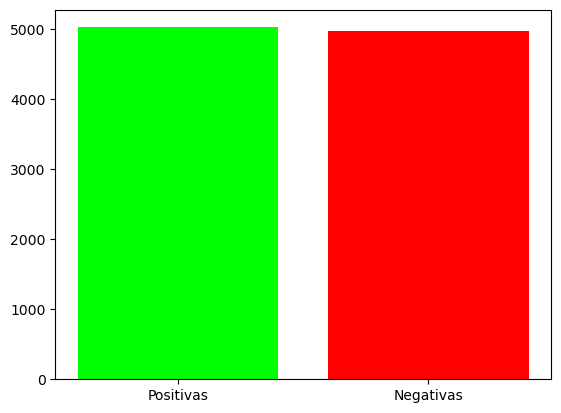

In [15]:
# Ver la distribución que tenemos de los datos 
Pos = 0
Neg = 0

for Sentiment in movie_reviews["sentimiento"]:
    if(Sentiment == 'positive'):
        Pos += 1
    else:
        Neg += 1

plt.bar(['Positivas', 'Negativas'], [Pos, Neg], color = ['lime', 'red'])

## Paso 2 - Preprocesamiento de la información

In [16]:
# Filtrado de StopWords utilizando NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('spanish'))

X = []

removedor_tags = re.compile(r'<[^>]+>')

sentences = list(movie_reviews['reseña'])
for sen in sentences:
    
    # Filtrado de stopword (REEMPLAZAR la SW con nada)
    for stopword in stop_words:
        sen = sen.replace(" " + stopword + " ", " ")
            
    # Remover los elementos de HTML (Que aparecen en los comentarios)
    sentence = removedor_tags.sub('', sen)
    # Remover espacios múltiples
    sentence = re.sub(r'\s+', ' ', sentence)
    # Convertir todo a minúsculas
    sentence = sentence.lower()
    # Filtrado de signos de puntuación
    tokenizer = RegexpTokenizer(r'\w+')
    # Tokenización del resultado (Aplicando el rechazo de tokens descrito)
    result = tokenizer.tokenize(sentence)
    # Agregar al arreglo los textos "destokenizados" (Como texto nuevamente)
    X.append(TreebankWordDetokenizer().detokenize(result))


In [17]:
# Filtrado de más StopWords (Definidas por el usuario)
New_StopWords = ['a','acá','ahí','al','algo','algún','alguna','alguno','algunas','algunos','allá','allí','ambos','ante',
                 'antes','aquel','aquella','aquello','aquellas','aquellos','aquí','arriba','así','atrás','aun','aunque',
                 'bien','cada','casi','como','con','cual','cuales','cualquier','cualquiera','cuan','cuando','cuanto','cuanta',
                 'cuantos','cuantas','de','del','demás','desde','donde','dos','el','él','ella','ello','ellas','ellos','en',
                 'eres','esa','ese','eso','esas','esos','esta','esto','estas','estos','este','etc','ha','hasta','la','lo','las',
                 'los','me','mi','mis','mía','mías','mío','míos','mientras','muy','ni','nosotras','nosotros','nuestra',
                 'nuestro','nuestras','nuestros','os','otra','otro','otras','otros','para','pero','pues','que','qué','si','sí',
                 'siempre','siendo','sin','sino','so','sobre','sr','sra','sres','sta','su','sus','te','tu','tus','un','una',
                 'uno','unas','unos','usted','ustedes','vosotras','vosotros','vuestra','vuestro','vuestras','vuestros','y','ya',
                 'yo']

for i in range(len(X)):
    for element in New_StopWords:
        X[i] = X[i].replace(" " + str(New_StopWords) + " ", " ")

print("Textos sin StopWords:")
X

Textos sin StopWords:


['uno críticos mencionado después ver sólo 1 episodio oz enganchado tienen razón exactamente sucedió conmigo lo primero llamó atención oz brutalidad escenas inquebrantable violencia conjunto derecha principio confía mí espectáculo débiles corazón tímida este espectáculo tira golpes respecto drogas sexo violencia su incondicional uso clásico palabra se llama oz apodo dado estado penitentary oswald máxima seguridad se centra principalmente ciudad esmeralda sección experimental prisión todas células frentes cristal cara hacia interior privacidad prioridad agenda em city hogar many aryans musulmanes gangstas latinos cristianos italianos irlandeses por tanto enfrentamientos miradas muerte relaciones fiables acuerdos turbios nunca lejos diría principal atractivo serie debe hecho va espectáculos atreverían olvidar bonitos cuadros pintados público mayoritario olvidar encanto olvidar romance oz hace perder tiempo el primer episodio visto parecido tan desagradable surrealista podía decir prepara

## Paso 3 - Creación de vectores / matrices de entrada y salida para el entrenamiento

In [18]:
# Creación del vector objetivo (Postivo / Negativo)
Sent = movie_reviews['sentimiento']

y = []
for Sentimiento in Sent: 
    # AGREGAR a la lista Y
    if Sentimiento == "positive":
        y.append(1)
    else:
        y.append(0)
print("Vector de objetivos:")
print(y)

Vector de objetivos:
[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

In [19]:
# Separación de la información en conjuntos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Preparamos la capa de embeddingsn(Predefinimos una cantidad de
# 5000 palabras consideradas como tokens
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Transforma cada texto en una secuencia de valores enteros
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
# Conversión de los conjuntos de entrenamiento a vectores 
maxlen = 100

# Aquellos mayores a 100 son truncados, y los menores les 
# es replicado su último valor para tener arreglos
# bidimensionales del mismo tamaño (Usar el método para padding)
X_train = _____(X_train, padding='post', maxlen=maxlen)
X_test = _____(X_test, padding='post', maxlen=maxlen)

print("Matriz de valores para las palabras:")
X_train.shape

NameError: name '_____' is not defined

In [ ]:
# Verificar que la información de entrada sea coherente
print(X_train)
print(y_train)

## Pasos 4 y 5 - Selección y aplicación del modelo de IA (DNN)

In [ ]:
# Declaración de librerías para manejo de arreglos (Numpy)
from _____ import asarray
from _____ import zeros

# Lectura del archivo de embeddings
embeddings_dictionary = dict()
Embeddings_file = _____('Word2Vect_Spanish.txt', encoding="utf8")

# Extraemos las características del archivo de embeddings
# y las agregamos a un diccionario (Cada elemento es un vector)
for linea in Embeddings_file:
    caracts = _____.split()
    palabra = caracts[0]
    vector = asarray(caracts[1:], dtype='float32')
    embeddings_dictionary [_____] = vector
Embeddings_file._____()

In [ ]:
# Extraemos la cantidad de palabras en el vocabulario
vocab_size = len(tokenizer.word_index) + 1

# Generamos la matriz de embeddings (De entrada llena de ceros)
embedding_matrix = _____((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    # Extraemos el vector de embedding para cada palabra
    embedding_vector = embeddings_dictionary._____(word)
    # Si la palbra si existía en el vocabulario
    # agregamos su vector de embeddings en la matriz
    if embedding_vector is not None:
        embedding_matrix[_____] = embedding_vector

In [ ]:
# Definimos las capas de nuestro modelo neuronal (DNN)
# Definimos que el modelo será secuencial (Y que ingresaremos cada capa en el orden de configuración de la red)
model = _____()
# Definimos los valores para nuestra capa de Embeddings
embedding_layer = Embedding(_____, _____, weights=[embedding_matrix], input_length=maxlen, trainable=False)
# Agregamos al modelo 3 capas (La de Embeddings, una de aplanamiento y una Dense con activación Sigmoindal)
model.add(embedding_layer)
model.add(_____())
model.add(Dense(1, activation='_____'))
# Definimos métodos de optimización, que métrica se utilizará y como calcular la pérdida
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# Para ver la configuración que definimos
print(model.summary())

In [ ]:
# Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
history = model._____(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
# Utilizamos evaluate para determinar la pérdida y el accuracy de nuestro modelo
score = model._____(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# Finalmente imprimimos la eficiencia y la pérdida del modelo
# época a época para ver su evolución
import matplotlib.pyplot as plt


plt.plot(history._____['acc'])
plt.plot(history._____['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history._____['loss'])
plt.plot(history._____['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Paso 5.1 - Aplicación de una Red Convolucional (CNN) 

In [ ]:
# Declaración de modelo Secuencial 
model = _____()

# Declaración de las capas del modelo convolucional
embedding_layer = _____(_____, _____, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(_____, ______, activation='_____'))
model.add(_____())
model.add(Dense(1, activation='_____'))
# Impresión de parámetros del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

In [ ]:
# Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
history = model._____(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
# Utilizamos evaluate para determinar la pérdida y el accuracy de nuestro modelo
score = model._____(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# Finalmente imprimimos la eficiencia y la pérdida del modelo
# época a época para ver su evolución
plt.plot(history._____['acc'])
plt.plot(history._____['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history._____['loss'])
plt.plot(history._____['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Paso 5.2 - Red LSTM

In [ ]:
# Declaración de modelo Secuencial 
model = Sequential()

# Declaración de las capas del modelo LSTM
embedding_layer = _____(_____, _____, weights=[_____], input_length=maxlen , trainable=False)
model.add(_____)
model.add(LSTM(_____))
model.add(Dense(1, activation='_____'))

# Impresión de parámetros del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

In [ ]:
# Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
history = model._____(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
# Utilizamos evaluate para determinar la pérdida y el accuracy de nuestro modelo
score = model._____(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# Finalmente imprimimos la eficiencia y la pérdida del modelo
# época a época para ver su evolución
plt.plot(history._____['acc'])
plt.plot(history._____['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history._____['loss'])
plt.plot(history._____['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Paso 6 - Probar el modelo

In [ ]:
instance = "Acabo de terminar esta película la vi en el estante de videos y, siendo fan de Nick Stahl, tuve que alquilarla. Con toda honestidad, probablemente debería haberse quedado en el estante. El concepto era interesante y hubo varios giros y vueltas bastante inteligentes, pero de alguna manera adiviné casi todos antes de que aparecieran. Y la película simplemente fue un poco demasiado lejos al final en mi opinión ... ¡si tienes que sufrir al verla, verás lo que quiero decir! En una nota positiva, Nick La actuación de Stahl fue genial (especialmente considerando con qué tuvo que trabajar). Eddie Kaye Thomas también fue bueno, pero siempre interpreta el mismo tipo de personaje ... demasiado Paul Finch de \"American Pie\" apareciendo para mi gusto. <br /> <br /> Y finalmente, la peor parte de esta película tiene que ser la actuación sin emociones de January Jones ... Supongo que una cara bonita es todo lo que importa en Hollywood."

# Tokenizamos el texto (Secuencias de enteros)
instance = tokenizer._____(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(_____)

flat_list = [flat_list]

instance = pad_sequences(flat_list, _____='post', maxlen=maxlen)

model.predict(instance)